In [1]:
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import seaborn as sns
import requests
import tqdm
import xswap

%matplotlib inline

In [2]:
def edges_to_mat(edges, sparse=False, shape=None):
    sp_mat = scipy.sparse.coo_matrix((np.ones(len(edges)), (zip(*edges))))
    if shape is None:
        shape = sp_mat.shape
    sp_mat = scipy.sparse.csc_matrix(sp_mat, shape=shape)
    if sparse:
        return sp_mat
    return sp_mat.toarray()

def rowsums(matrix, shape):
    return np.repeat(
       matrix
       .sum(axis=1)
       .reshape(shape[0], 1),
       shape[1],
       axis=1)

def colsums(matrix, shape):
    return np.repeat(
       matrix
       .sum(axis=0)
       .reshape(1, shape[1]),
       shape[0],
       axis=0)

def compute_probs(mat):
    N = mat.sum()
    aata = mat @ (mat.T) @ mat
    S = (1/2) * (N**2 + np.trace(aata @ mat.T) - 2 * aata.sum())
    rho = mat * (N - rowsums(mat @ mat.T, mat.shape) 
                 - colsums(mat.T @ mat, mat.shape) + aata)
    R = 1 - rho / S
    t = (1 - mat) * (rowsums(mat, mat.shape) * colsums(mat, mat.shape) - aata)
    T = t / S
    D = R - T
    return D, T

# def compute_probs_sparse(mat):
#     dense = mat.toarray()
#     N = mat.sum()
#     aata = mat @ (mat.T) @ mat
#     S = (1/2) * (N**2 + (aata @ mat.T).diagonal().sum() - 2 * aata.sum())
#     rho = dense * (N - rowsums((mat @ mat.T).toarray(), shape=(19769, 19769)) 
#                    - colsums((mat.T @ mat).toarray(), shape=(19769, 19769)) 
#                    + aata.toarray())
#     T = (1 - dense) * (rowsums(dense, shape=(19769, 19769)) * colsums(dense, shape=(19769, 19769)) 
#                        - aata.toarray()) / S
#     D = 1 - rho / S - T
#     return D, T

In [3]:
def xswap(adj_list, num_success):
    adj_list = edges.copy()
    success = 0
    while success < num_success:
        ind = np.arange(len(adj_list))
        ind_a, ind_b = np.random.choice(ind, size=2, replace=False)
        edge_a, edge_b = adj_list[ind_a], adj_list[ind_b]

        next_a = (edge_a[0], edge_b[1])
        next_b = (edge_b[0], edge_a[1])

        if next_a not in edges and next_b not in edges:
            adj_list[ind_a] = next_a
            adj_list[ind_b] = next_b
            success += 1
    return adj_list

In [26]:
edges = [(0,0), (0,1), (1,2), (1,3), (2,4), (3,4)]
mat_shape = (4, 5)

In [5]:
num_indicators = 5
indicators = {n: np.zeros(mat_shape) for n in range(1, num_indicators + 1)}

success = 100000
for _ in tqdm.tnrange(success):
    for n in range(1, num_indicators + 1):
        permuted_edges = xswap(edges, n)
        permuted = scipy.sparse.coo_matrix((np.ones(len(edges)), (zip(*permuted_edges))), shape=mat_shape)
        indicators[n] += permuted.toarray()

for n in range(1, num_indicators + 1):
    indicators[n] /= success

In [6]:
graphs = list()
for _ in range(10000):
    permuted = xswap(edges, 1)
    permuted = ([edge for edge in permuted if edge[0] <= edge[1]] 
                + [(edge[1], edge[0]) for edge in permuted if edge[0] > edge[1]])
    permuted = sorted(permuted)
    if permuted not in graphs:
        graphs.append(permuted)

len(graphs)

45

In [7]:
# Small example matrix
mat = np.zeros(mat_shape)
for edge in edges:
    mat[edge] = 1
D, T = compute_probs(mat)

S = (1/2) * (np.trace(mat@mat.T@mat@mat.T) + mat.sum()**2 - 2 * (mat@mat.T@mat).sum())
print(S)

analyticals = dict()
analyticals[0] = mat
for n in range(1, num_indicators + 1):
    analyticals[n] = T + analyticals[n-1] * D
    
non_stationary = dict()
non_stationary[0] = mat
for n in range(1, num_indicators + 1):
    T_n, D_n = compute_probs(non_stationary[n-1])
    non_stationary[n] = T_n + non_stationary[n-1] * D

45.0


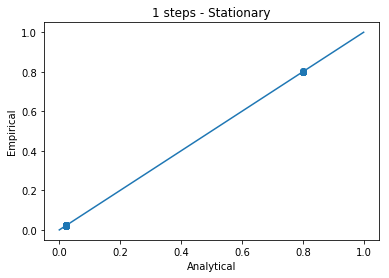

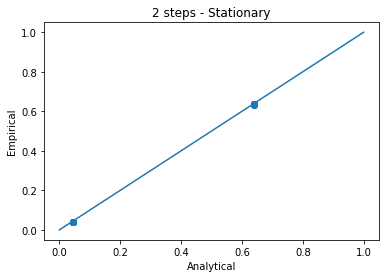

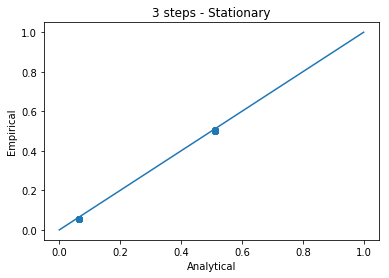

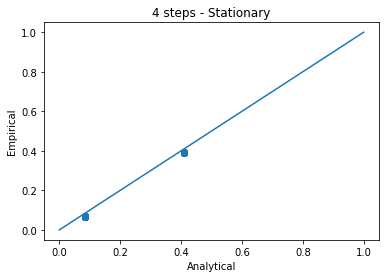

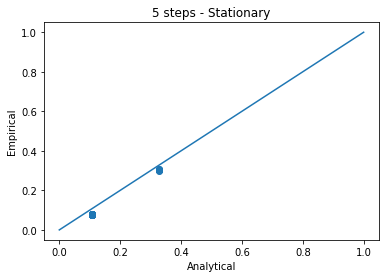

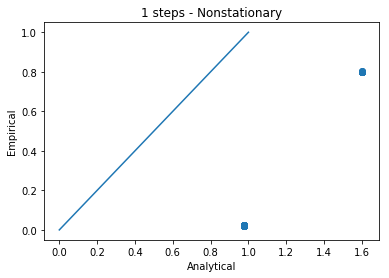

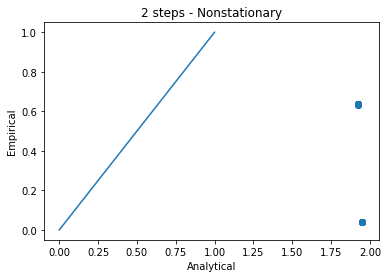

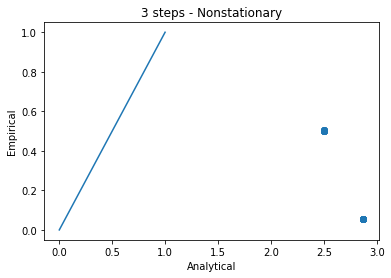

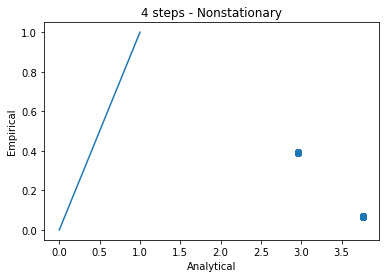

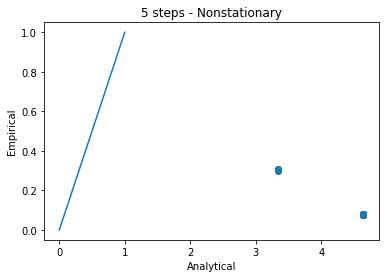

In [8]:
for i in range(1, num_indicators + 1):
    plt.figure()
    plt.scatter(analyticals[i].flatten(), indicators[i].flatten())
    plt.plot([0,1], [0,1])
    plt.xlabel('Analytical')
    plt.ylabel('Empirical')
    plt.title(f'{i} steps - Stationary')
    
for i in range(1, num_indicators + 1):
    plt.figure()
    plt.scatter(non_stationary[i].flatten(), indicators[i].flatten())
    plt.plot([0,1], [0,1])
    plt.xlabel('Analytical')
    plt.ylabel('Empirical')
    plt.title(f'{i} steps - Nonstationary')

In [9]:
# TODO: Something is wrong here, probabilities do not remain normalized

non_stationary[2].max()

1.9513813021133317

## What factors are conserved?

In [27]:
a = edges_to_mat(edges, shape=mat_shape)
a_n = edges_to_mat(xswap(edges,1), shape=mat_shape)

In [28]:
a_n

array([[0., 1., 1., 0., 0.],
       [1., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [29]:
a_n@a_n.T

array([[2., 0., 0., 0.],
       [0., 2., 0., 0.],
       [0., 0., 1., 1.],
       [0., 0., 1., 1.]])

In [30]:
(a@a.T@a)

array([[2., 2., 0., 0., 0.],
       [0., 0., 2., 2., 0.],
       [0., 0., 0., 0., 2.],
       [0., 0., 0., 0., 2.]])

In [31]:
(a_n@a_n.T@a_n)

array([[0., 2., 2., 0., 0.],
       [2., 0., 0., 2., 0.],
       [0., 0., 0., 0., 2.],
       [0., 0., 0., 0., 2.]])

In [32]:
def compute_probs(mat):
    N = mat.sum()
    aata = mat @ (mat.T) @ mat
    S = (1/2) * (N**2 + np.trace(aata @ mat.T) - 2 * aata.sum())
    rho = mat * (N - rowsums(mat @ mat.T, mat.shape) 
                 - colsums(mat.T @ mat, mat.shape) + aata)
    R = 1 - rho / S
    t = (1 - mat) * (rowsums(mat, mat.shape) * colsums(mat, mat.shape) - aata)
    T = t / S
    D = R - T
    return S, R, T

In [51]:
mat = np.array([
    [1,1,0],
    [0,1,1]
])

In [43]:
mat = np.array([
    [0,0,1,1,0],
    [0,0,0,1,1],
    [1,0,0,0,0],
    [1,1,0,0,0],
    [0,1,0,0,0]
])

In [52]:
mat@mat.T@mat@mat.T

array([[5, 4],
       [4, 5]])

In [53]:
mat@mat.T

array([[2, 1],
       [1, 2]])

In [34]:
s, r, t = compute_probs(a)

In [35]:
s

12.0

In [36]:
r

array([[0.66666667, 0.66666667, 1.        , 1.        , 1.        ],
       [1.        , 1.        , 0.66666667, 0.66666667, 1.        ],
       [1.        , 1.        , 1.        , 1.        , 0.66666667],
       [1.        , 1.        , 1.        , 1.        , 0.66666667]])

In [37]:
t

array([[0.        , 0.        , 0.16666667, 0.16666667, 0.33333333],
       [0.16666667, 0.16666667, 0.        , 0.        , 0.33333333],
       [0.08333333, 0.08333333, 0.08333333, 0.08333333, 0.        ],
       [0.08333333, 0.08333333, 0.08333333, 0.08333333, 0.        ]])

In [46]:
sn, rn, tn = compute_probs(a_n)

In [47]:
sn

12.0

In [48]:
rn

array([[1.        , 0.66666667, 0.66666667, 1.        , 1.        ],
       [0.66666667, 1.        , 1.        , 0.66666667, 1.        ],
       [1.        , 1.        , 1.        , 1.        , 0.66666667],
       [1.        , 1.        , 1.        , 1.        , 0.66666667]])

In [49]:
tn

array([[0.16666667, 0.        , 0.        , 0.16666667, 0.33333333],
       [0.        , 0.16666667, 0.16666667, 0.        , 0.33333333],
       [0.08333333, 0.08333333, 0.08333333, 0.08333333, 0.        ],
       [0.08333333, 0.08333333, 0.08333333, 0.08333333, 0.        ]])

## Larger graph

This turns out to take way too much memory unless you are very careful